### Run QG model to equilibrium and plot KE & PV

Spin up QG model and save equilibriated state. We will use `run_with_snapshots` and `get_diagnostic` to save the PV anomaly and mean eddy kinetic energy. The model config from [Zhang et al. 2020](https://www.mdpi.com/2311-5521/5/1/2) using a two-layer QG model is used to mimic the Southern Ocean.


In [1]:
import os
import numpy as np
import xarray as xr
import pyqg
# from pyqg import diagnostic_tools as tools
# from pyqg import qg_model, particles
import matplotlib.pyplot as plt

#### Model Configuration

In [2]:
day = 3600*24
year = 360*day
dt = day/72/2  # time step  

L = 1200e3   # domain size
Ld = 15e3  # Rossby deformation radius
nx = 256*2  # number of grid points in x direction

delta = 0.25
H1 = 4000*(delta/(1+delta)) #upper layer thickness [m]

U1 = 0.04  # layer 1 zonal velocity [m/s]
U2 = 0.0   # layer 2 zonal velocity [m/s]

rekday = 20
rek =  1/(rekday*day)   # linear bottom drag coeff. [s^-1] 
f0 = -1.2e-4    # Coriolis param. [s^-1]
beta = 1.3e-11  # planatery vorticity gradient [m^-1 s^-1]

Ti = Ld/abs(U1)
tmax = 10*year # tmax is like seconds in 10 years

In [3]:
# Initialize QG Model
m = pyqg.QGModel(nx=nx, L=L,dt=dt, tmax=tmax, twrite=50000, tavestart=10*year, 
               ntd=6, beta=beta, rd=Ld, delta=delta, H1=H1, U1=U1, U2=U2, rek=rek) 

INFO:  Logger initialized


In [4]:
# Set upper and lower layer PV anomalies (in spatial coordinates):
sig = 1.e-6
qi = sig*np.vstack([np.random.randn(m.nx,m.ny)[np.newaxis,],
                  np.random.randn(m.nx,m.ny)[np.newaxis,]])
m.set_q(qi) 

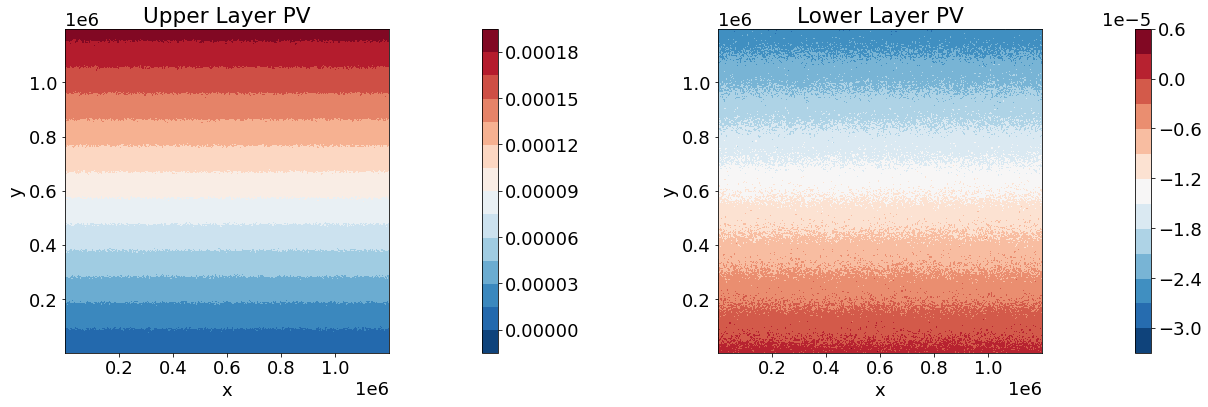

In [5]:
# Plot initialized PV on ensemble member 1
qi_upper = m.q[0] + m.Qy[0]*m.y
qi_lower = m.q[1] + m.Qy[1]*m.y

plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 18})

plt.subplot(121)
plt.contourf(m.x, m.y, qi_upper, 12, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Upper Layer PV')
plt.colorbar(); plt.axis('square')

plt.subplot(122)
plt.contourf(m.x, m.y, qi_lower, 12, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Lower Layer PV')
plt.colorbar(); plt.axis('square')

plt.tight_layout();

In [ ]:
# run with snapshots, save model increments as xarray DataSet
# make a new directory and switch to it
# os.mkdir('/burg/abernathey/users/hillary/spin_up/')

for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=m.dt):
    model = m.to_dataset()
    fn = '/burg/abernathey/users/hillary/spin_up/QG_zhang20_config_'+ str('%d'%model.time.values[0]) +'.nc'
    model.to_netcdf(fn, engine='h5netcdf', invalid_netcdf=True, mode='a')

